# Monte Carlo Validation of Random Forest Models by Fire and NLCD
We applied a Monte Carlo spatial subsampling validation (1000 iterations, ~300 m block size) to evaluate Random Forest predictions of dNBR, stratified by fire and by NLCD land cover class.
- By running many Monte Carlo iterations with different random seeds, we repeatedly draw different spatial subsamples of pixels (using the ~300 m block subsampling).
- For each subsample, we split into train/test, fit the Random Forest, and compute metrics (R², RMSE, MAE).
- The distribution of results across iterations informs how sensitive the model’s performance is to the particular subset of data chosen.
- By grouping results per fire or per NLCD class, we evaluate whether performance stability differs depending on fire characteristics or vegetation type.

**Per-Fire Monte Carlo Validation** :
How much does model performance vary just from the spatial sampling process?
- Train/test splits preserve proportional representation of Eaton, Hughes, Palisades
- The variation across iterations comes only from which pixels within each fire are chosen by the block subsampling
- Per-fire = sensitivity to subsampling within fire boundaries

**NLCD Monte Carlo Evaluation** :
How stable is performance when evaluated per vegetation class, regardless of fire?
- Train/test split is driven by vegetation classes, not by fire perimeter
- The variation across iterations comes from different subsampled pixels per class + class-stratified splits
- Per-NLCD = sensitivity to subsampling within vegetation classes

In [15]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask as rio_mask
from shapely.geometry import mapping
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set default font family to Arial
mpl.rcParams["font.family"] = "Arial"

In [2]:
wildfire_rasters = {
    "Eaton": {
        "burn_perimeter": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/data/allfires_model/burnperimeters/Eaton_WFIGS_Interagency_Perimeters_YearToDate_-8396875942426194654/Perimeters_inward100m.shp",
        "stacked": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/updated_allfiresmodel/Eaton/Eaton_LayerStack_updated20250902",
        "mask": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/updated_allfiresmodel/Eaton/NLCD_Eaton_mask_resampled.tif",
        "nlcd_raster": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/updated_allfiresmodel/Eaton/NLCD_Eaton_resampled.tif"
    },
    "Hughes": {
        "burn_perimeter": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/data/allfires_model/burnperimeters/Hughes_WFIGS_Interagency_Perimeters_YearToDate_7148479240675437113/Perimeters_inward100m.shp",
        "stacked": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/updated_allfiresmodel/Hughes/Hughes_layerstack_updated_20250902",
        "mask": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/updated_allfiresmodel/Hughes/NLCD_Hughes_mask_resampled.tif",
        "nlcd_raster": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/updated_allfiresmodel/Hughes/NLCD_Hughes_resampled.tif"
    },
    "Palisades": {
        "burn_perimeter": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/data/allfires_model/burnperimeters/Palisades_WFIGS_Interagency_Perimeters_YearToDate_2024716492027912883/Perimeters_inward100m.shp",
        "stacked": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/updated_allfiresmodel/Palisades/Palisades_LayerStack_updated20250902",
        "mask": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/updated_allfiresmodel/Palisades/NLCD_Palisades_mask_resampled.tif",
        "nlcd_raster": "/Volumes/GEOG/EMIT_ECOSTRESS_wildfires/updated_allfiresmodel/Palisades/NLCD_Palisades_resampled.tif"
    }
}

band_mappings = {
    fire: {
        1: "CWC_20240625",
        7: "ESI_20240625_1038am",
        10: "ESI_20241201_1049am",
        17: "WUE_20230409_1028am",
        38: "Elevation",
        41: "cosAspect",
        45: "WindGust_max_20250108",
        51: "dNBR"
    } for fire in wildfire_rasters
}

nlcd_classes = {
    11: 'Open Water', 12: 'Perennial Ice/Snow', 21: 'Developed, Open Space',
    22: 'Developed, Low Intensity', 23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity', 31: 'Barren Land', 41: 'Deciduous Forest',
    42: 'Evergreen Forest', 43: 'Mixed Forest', 52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous', 81: 'Pasture/Hay', 82: 'Cultivated Crops',
    90: 'Woody Wetlands', 95: 'Emergent Herbaceous Wetlands'
}

continuous_vars = sorted([v for v in band_mappings["Eaton"].values() if v != "dNBR"])


def random_subsample_mask(valid_mask, block_size, seed):
    """
    Selects one random valid pixel per block (~300 m if block_size=5 with 60 m pixels).

    Returns
    -------
    out : np.ndarray (bool [H, W])
        Mask of sampled pixels (True = selected).
    """
    rng = np.random.default_rng(seed)
    H, W = valid_mask.shape
    out = np.zeros_like(valid_mask, dtype=bool)
    for r0 in range(0, H, block_size):
        for c0 in range(0, W, block_size):
            block = valid_mask[r0:r0+block_size, c0:c0+block_size]
            if not block.any():
                continue
            rr, cc = np.where(block)
            k = rng.integers(0, len(rr))
            out[r0 + rr[k], c0 + cc[k]] = True
    return out

def load_predictor_and_target_bands(raster_path, burn_perimeter_gdf, band_map, mask_path, nlcd_path=None):
    """
    Load predictors and dNBR target from a stacked raster for one fire.

    Parameters
    ----------
    raster_path : str
        Path to stacked predictor raster.
    burn_perimeter_gdf : GeoDataFrame
        Burn perimeter geometry.
    band_map : dict
        Mapping of band indices to variable names.
    mask_path : str
        Path to binary mask raster (0/1).
    nlcd_path : str, optional
        Path to NLCD raster for class labels.

    Returns
    -------
    predictors : np.ndarray [n_vars, H, W]
    target : np.ndarray [H, W]
    predictor_names_out : list
    profile : dict
    mask_data : np.ndarray [H, W]
    nlcd_data : np.ndarray [H, W] or None
    """
    with rasterio.open(raster_path) as src:
        geom_src = [mapping(burn_perimeter_gdf.to_crs(src.crs).geometry.union_all())]
        all_bands_data, transform = rio_mask(src, geom_src, crop=True, nodata=-9999)
        all_bands_data = all_bands_data.astype(np.float32)
        all_bands_data[all_bands_data == -9999] = np.nan
        profile = src.profile

    with rasterio.open(mask_path) as mask_src:
        geom_mask = [mapping(burn_perimeter_gdf.to_crs(mask_src.crs).geometry.union_all())]
        mask_clipped, _ = rio_mask(mask_src, geom_mask, crop=True, nodata=0)
        mask_data = mask_clipped[0, :, :]

    nlcd_data = None
    if nlcd_path is not None:
        with rasterio.open(nlcd_path) as nlcd_src:
            geom_nlcd = [mapping(burn_perimeter_gdf.to_crs(nlcd_src.crs).geometry.union_all())]
            nlcd_clipped, _ = rio_mask(nlcd_src, geom_nlcd, crop=True, nodata=0)
            nlcd_data = nlcd_clipped[0, :, :]

    predictors, predictor_names_out = [], []
    target = None
    for band_num, name in band_map.items():
        band = all_bands_data[band_num - 1, :, :]
        if name == "dNBR":
            target = band
        else:
            predictors.append(band)
            predictor_names_out.append(name)

    if target is None:
        raise RuntimeError("Target 'dNBR' not found in band_map.")

    predictors = np.array(predictors)
    if predictors.shape[1:] != mask_data.shape:
        raise ValueError(f"Shape mismatch: predictors {predictors.shape[1:]} vs mask {mask_data.shape}")

    return predictors, target, predictor_names_out, profile, mask_data, nlcd_data

    
# -----------------------------
# Monte Carlo loop
# -----------------------------
def run_montecarlo_eval(
    wildfire_rasters, band_mappings, continuous_vars,
    n_iterations=1000, block_size=5, test_size=0.3,
    mode="fire"
):
    """
    Monte Carlo evaluation of Random Forest regression models for burn severity (dNBR).

    This function repeatedly subsamples raster data across multiple fires,
    applies feature scaling, trains Random Forest models, and evaluates
    predictive performance under two possible grouping schemes:
    (1) by wildfire (mode="fire") or (2) by NLCD land-cover class (mode="nlcd").

    Parameters
    ----------
    wildfire_rasters : dict
        Dictionary keyed by fire name. Each value is a dict with paths:
        {
            "burn_perimeter": str,  # Shapefile of inward-clipped burn perimeter
            "stacked": str,         # Multiband raster of predictors + dNBR
            "mask": str,            # Binary (0/1) mask raster aligned to stacked raster
            "nlcd_raster": str      # NLCD raster aligned to stacked raster 
        }

    band_mappings : dict
        Dictionary keyed by fire name, with values mapping raster band indices (int)
        to variable names (str). Must include "dNBR" for target.

    continuous_vars : list of str
        Names of continuous predictor variables to include in scaling and modeling.

    n_iterations : int, default=1000
        Number of Monte Carlo iterations (unique random seeds).

    block_size : int, default=5
        Size of block for ~300 m subsampling. For ~60 m pixels, block_size=5
        selects one random valid pixel per 5x5 block.

    test_size : float, default=0.3
        Proportion of data held out for testing in each iteration.

    mode : {"fire", "nlcd"}, default="fire"
        Evaluation mode:
        - "fire": stratifies train/test splits by fire, computes per-fire metrics.
        - "nlcd": stratifies by NLCD classes, computes per-class metrics.

    Returns
    -------
    results_df : pandas.DataFrame
        DataFrame with one row per seed × group combination. Columns include:
        - "Seed": random seed used for subsampling and model training
        - "Group": "All" for overall performance, or group-specific ("fire_Eaton",
          "nlcd_42", etc.)
        - "R2": coefficient of determination
        - "RMSE": root mean squared error
        - "MAE": mean absolute error

    Notes
    -----
    - A global StandardScaler is fit once across all fires and applied consistently
      across iterations.
    - Subsampling reduces spatial autocorrelation by selecting ≤1 valid pixel
      per block.
    - Group-specific metrics are only reported for groups with ≥10 test samples.
    - Random Forest hyperparameters (n_estimators, max_depth, etc.) are fixed
      but can be adjusted in the function body.
    """

    results = []

    # -----------------------------
    # Fit global scaler once
    # -----------------------------
    fit_frames = []
    for fire, paths in wildfire_rasters.items():
        burn_perimeter = gpd.read_file(paths["burn_perimeter"])
        out = load_predictor_and_target_bands(
            paths["stacked"], burn_perimeter, band_mappings[fire],
            paths["mask"], paths.get("nlcd_raster")  # only needed in NLCD mode
        )
        predictors, target, pred_names, profile, mask_data, nlcd_data = out
        if mode == "fire":
            nlcd_data = None

        valid = (~np.isnan(target)) & (mask_data == 1)
        flat_preds = predictors[:, valid].T
        data = {name: flat_preds[:, i] for i, name in enumerate(pred_names)}
        data["dNBR"] = target[valid].ravel()
        data["Fire"] = fire
        if mode == "nlcd":
            data["NLCD"] = nlcd_data[valid].ravel()
        fit_frames.append(pd.DataFrame(data).dropna())

    df_fit = pd.concat(fit_frames, ignore_index=True)
    scaler = StandardScaler().fit(df_fit[continuous_vars])

    # -----------------------------
    # Monte Carlo loop
    # -----------------------------
    for seed in tqdm.trange(n_iterations, desc=f"Monte Carlo ({mode})"):
        df_parts = []
        for fire, paths in wildfire_rasters.items():
            burn_perimeter = gpd.read_file(paths["burn_perimeter"])
            out = load_predictor_and_target_bands(
                paths["stacked"], burn_perimeter, band_mappings[fire],
                paths["mask"], paths.get("nlcd_raster")
            )
            predictors, target, pred_names, profile, mask_data, nlcd_data = out
            if mode == "fire":
                nlcd_data = None

            valid = (~np.isnan(target)) & (mask_data == 1)
            subsample = random_subsample_mask(valid, block_size, seed)

            flat_preds = predictors[:, subsample].T
            data = {name: flat_preds[:, i] for i, name in enumerate(pred_names)}
            data["dNBR"] = target[subsample].ravel()
            data["Fire"] = fire
            if mode == "nlcd":
                data["NLCD"] = nlcd_data[subsample].ravel()
            df_parts.append(pd.DataFrame(data).dropna())

        df_mc = pd.concat(df_parts, ignore_index=True)

        X = scaler.transform(df_mc[continuous_vars])
        y = df_mc["dNBR"].values

        # Train/test split
        if mode == "fire":
            fire_labels = df_mc["Fire"].values
            idx = np.arange(len(df_mc))
            idx_train, idx_test = train_test_split(
                idx, test_size=test_size, random_state=seed, stratify=fire_labels
            )
            X_train, X_test = X[idx_train], X[idx_test]
            y_train, y_test = y[idx_train], y[idx_test]
            labels_test = fire_labels[idx_test]
        else:
            nlcd_vals = df_mc["NLCD"].values
            X_train, X_test, y_train, y_test, labels_train, labels_test = train_test_split(
                X, y, nlcd_vals, test_size=test_size, random_state=seed
            )

        # Train RF
        model = RandomForestRegressor(
            n_estimators=300, max_depth=12,
            min_samples_split=10, min_samples_leaf=5,
            max_features="sqrt", random_state=seed, n_jobs=-1
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Overall metrics
        results.append({
            "Seed": seed, "Group": "All",
            "R2": r2_score(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "MAE": mean_absolute_error(y_test, y_pred)
        })

        # Group-specific metrics
        for label in np.unique(labels_test):
            mask = labels_test == label
            if mask.sum() < 10:
                continue
            results.append({
                "Seed": seed,
                "Group": f"{mode}_{label}",
                "R2": r2_score(y_test[mask], y_pred[mask]),
                "RMSE": np.sqrt(mean_squared_error(y_test[mask], y_pred[mask])),
                "MAE": mean_absolute_error(y_test[mask], y_pred[mask])
            })

    return pd.DataFrame(results)

In [3]:
# Fire-wise evaluation
results_fire = run_montecarlo_eval(
    wildfire_rasters, band_mappings, continuous_vars, mode="fire"
)

Monte Carlo (fire): 100%|███████████████████| 1000/1000 [21:21<00:00,  1.28s/it]


In [4]:
# NLCD-wise evaluation
results_nlcd = run_montecarlo_eval(
    wildfire_rasters, band_mappings, continuous_vars, mode="nlcd"
)

Monte Carlo (nlcd): 100%|███████████████████| 1000/1000 [21:28<00:00,  1.29s/it]


In [16]:
def plot_mc_results(results_df, mode="fire", save_prefix=None):
    """
    Generate publication-quality plots summarizing Monte Carlo evaluation results.

    Parameters
    ----------
    results_df : pandas.DataFrame
        Output of run_montecarlo_eval. Must include columns:
        ["Seed", "Group", "R2", "RMSE", "MAE"].
    mode : {"fire", "nlcd"}, default="fire"
        Evaluation mode used ("fire" or "nlcd") for plot labeling.
    save_prefix : str or None, default=None
        If provided, saves plots as "<save_prefix>_<plotname>.png".
        Otherwise, displays interactively.
    """
    sns.set(style="whitegrid", context="talk")

    # -----------------------------
    # 1. Summary Table (mean ± std)
    # -----------------------------
    summary = (
        results_df.groupby("Group")[["R2", "RMSE", "MAE"]]
        .agg(["mean", "std"])
        .round(3)
    )
    print("\nSummary statistics (mean ± std):")
    print(summary)

    # -----------------------------
    # 2. R² across iterations (line plot)
    # -----------------------------
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df[results_df["Group"] != "All"],
        x="Seed", y="R2", hue="Group", alpha=0.6
    )
    plt.axhline(0, color="black", lw=1)
    plt.title(f"Monte Carlo R² across iterations ({mode}-wise)")
    plt.ylabel("R²")
    plt.xlabel("Iteration")
    plt.legend(title=mode.capitalize())
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_r2_iterations.png", dpi=300)
    else:
        plt.show()

    # -----------------------------
    # 3. R² distribution per group
    # -----------------------------
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        data=results_df[results_df["Group"] != "All"],
        x="Group", y="R2", inner="quartile", cut=0
    )
    plt.title(f"Distribution of R² per {mode.capitalize()}")
    plt.ylabel("R²")
    plt.xlabel(mode.capitalize())
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_r2_distribution.png", dpi=300)
    else:
        plt.show()

    # -----------------------------
    # 4. Validation metrics (R², RMSE, MAE)
    # -----------------------------
    metrics_melted = pd.melt(
        results_df[results_df["Group"] == "All"],
        id_vars=["Seed"], value_vars=["R2", "RMSE", "MAE"],
        var_name="Metric", value_name="Score"
    )
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metrics_melted, x="Metric", y="Score")
    plt.title(f"Monte Carlo Validation Metrics ({mode}-wise, All Groups)")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_metrics_boxplot.png", dpi=300)
    else:
        plt.show()

    # -----------------------------
    # 5. Histogram of R² (overall)
    # -----------------------------
    plt.figure(figsize=(8, 6))
    sns.histplot(
        results_df.loc[results_df["Group"] == "All", "R2"],
        bins=30, kde=True, color="steelblue"
    )
    plt.title(f"Distribution of Overall R² ({mode}-wise)")
    plt.xlabel("R²")
    plt.ylabel("Frequency")
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_r2_hist.png", dpi=300)
    else:
        plt.show()

    # -----------------------------
    # 6. RMSE vs R² scatter
    # -----------------------------
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=results_df[results_df["Group"] == "All"],
        x="RMSE", y="R2", alpha=0.5
    )
    plt.title(f"RMSE vs R² across Monte Carlo Runs ({mode}-wise)")
    plt.xlabel("RMSE")
    plt.ylabel("R²")
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_rmse_vs_r2.png", dpi=300)
    else:
        plt.show()

# Plot evaluation results


Summary statistics (mean ± std):
                   R2          RMSE           MAE       
                 mean    std   mean    std   mean    std
Group                                                   
All             0.598  0.024  0.119  0.004  0.087  0.003
fire_Eaton      0.371  0.062  0.160  0.010  0.119  0.008
fire_Hughes     0.677  0.047  0.082  0.007  0.061  0.004
fire_Palisades  0.574  0.033  0.107  0.005  0.083  0.003

Summary statistics (mean ± std):
            R2          RMSE           MAE       
          mean    std   mean    std   mean    std
Group                                            
All      0.599  0.025  0.119  0.004  0.087  0.003
nlcd_42  0.279  0.084  0.213  0.018  0.172  0.016
nlcd_43  0.213  0.103  0.128  0.009  0.102  0.007
nlcd_52  0.619  0.029  0.098  0.004  0.073  0.003
nlcd_71  0.084  0.506  0.091  0.024  0.068  0.016
nlcd_90  0.351  0.428  0.147  0.044  0.116  0.031


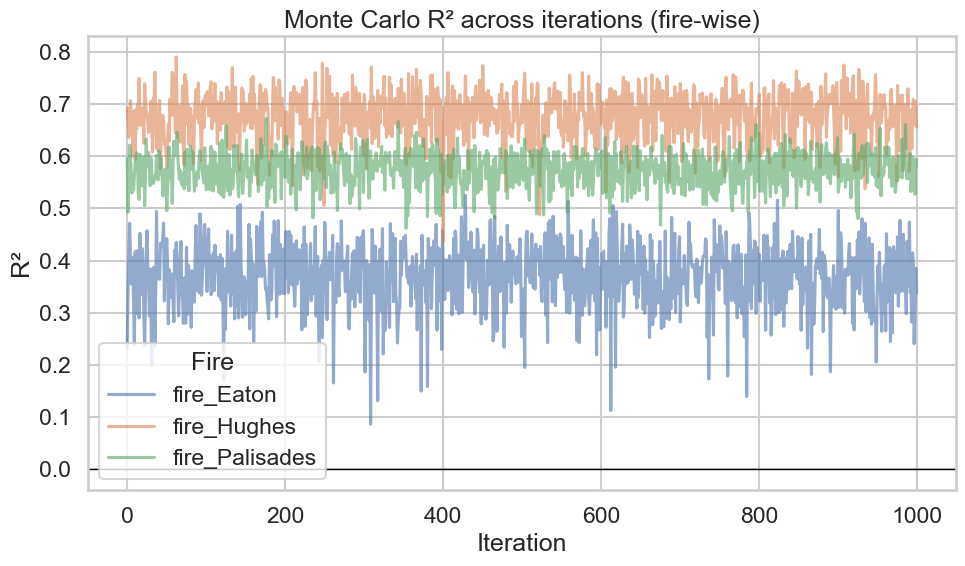

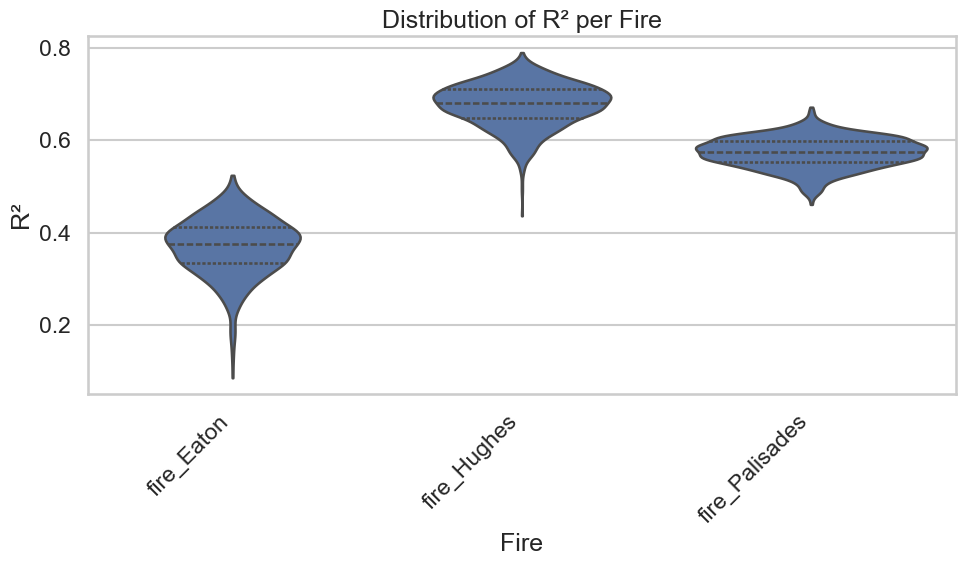

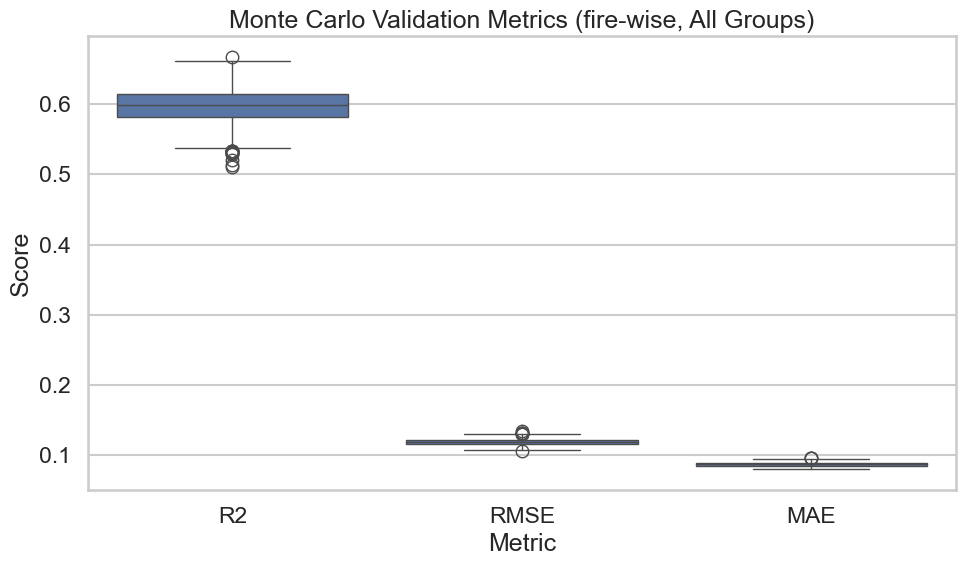

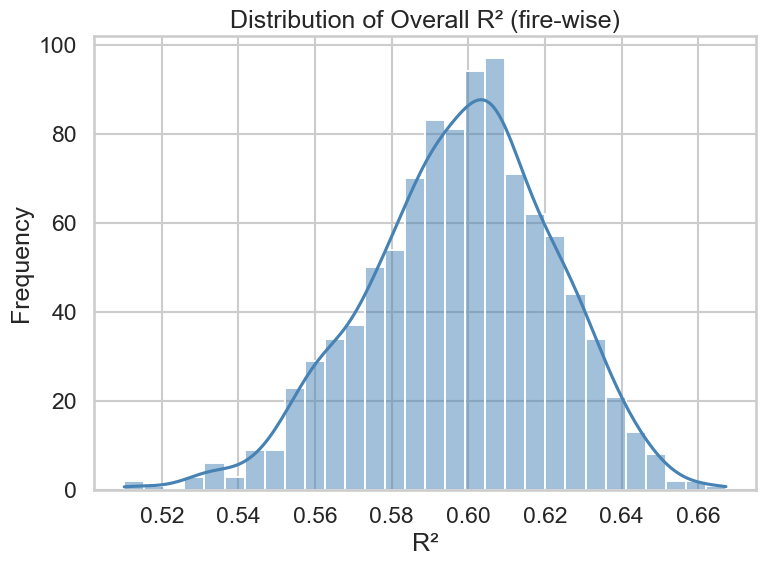

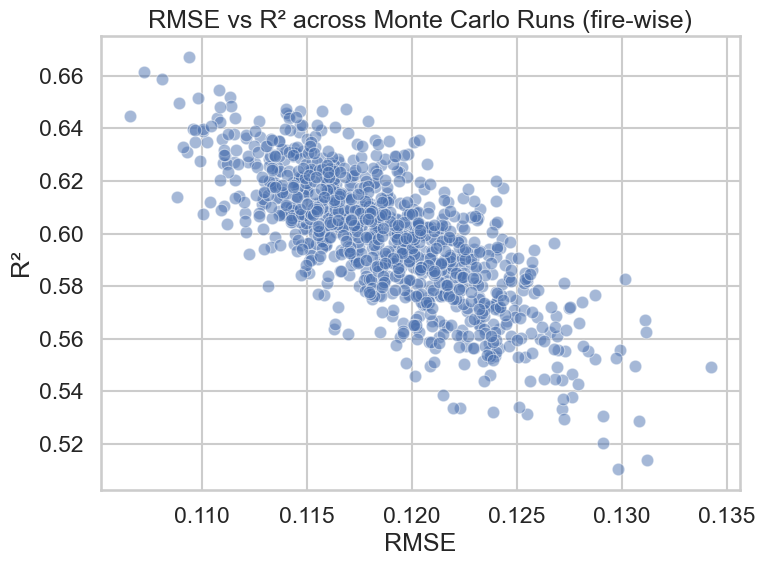

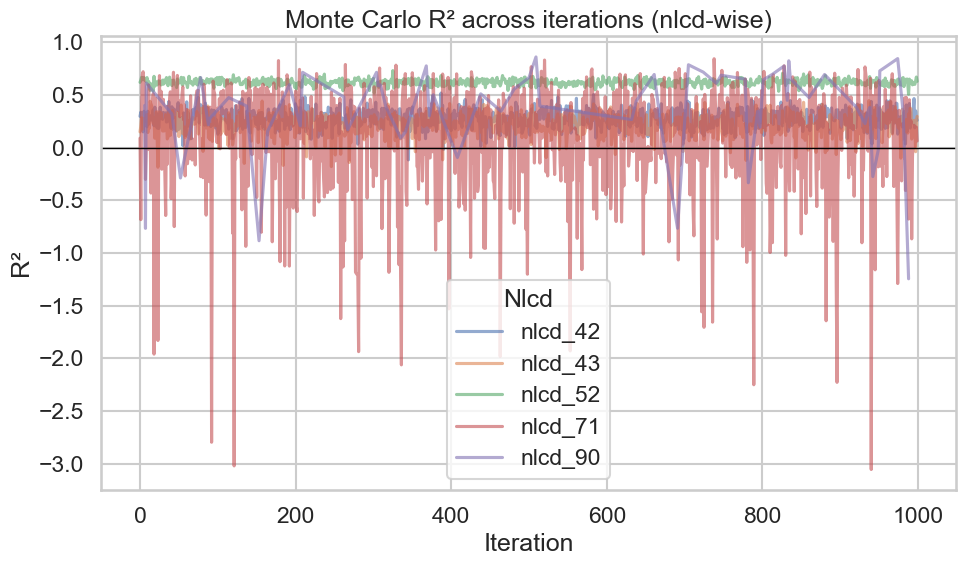

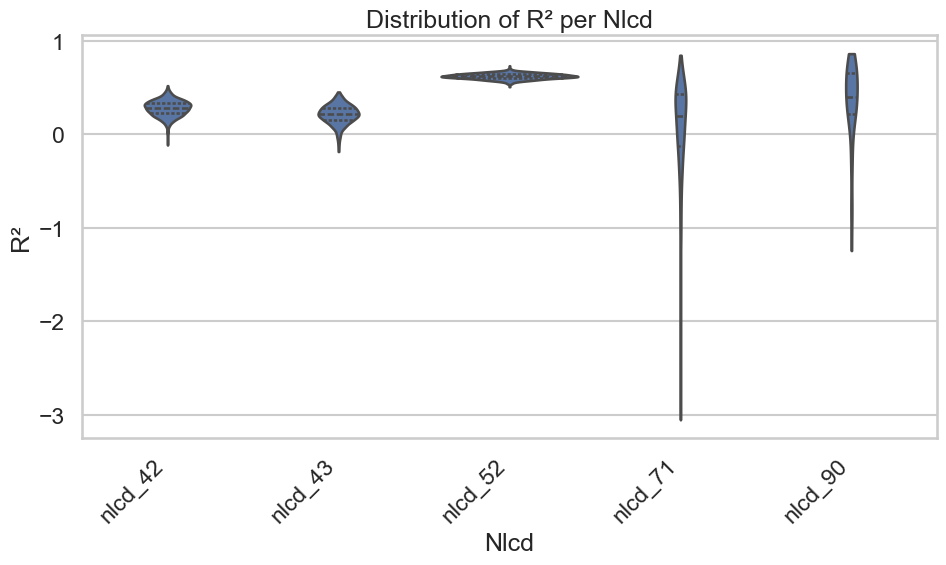

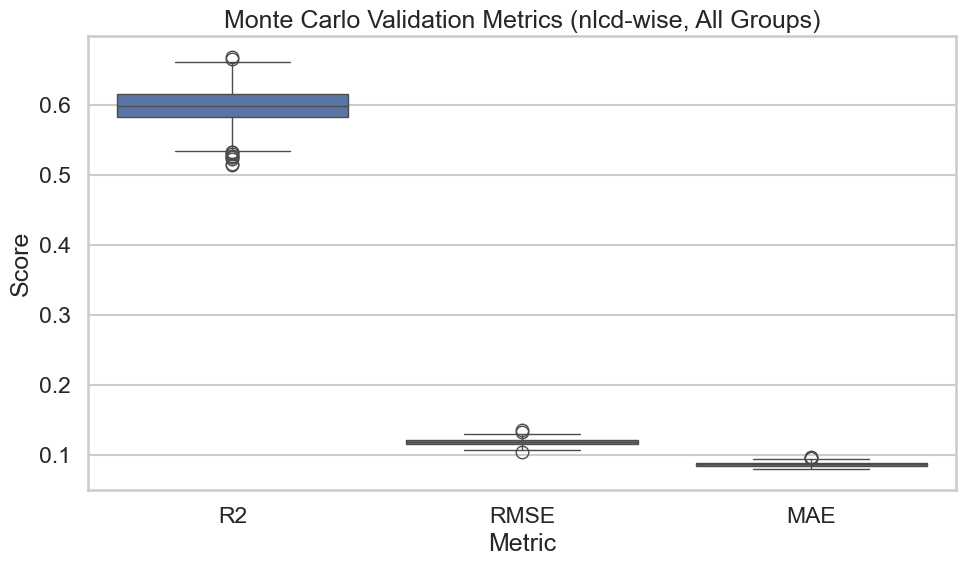

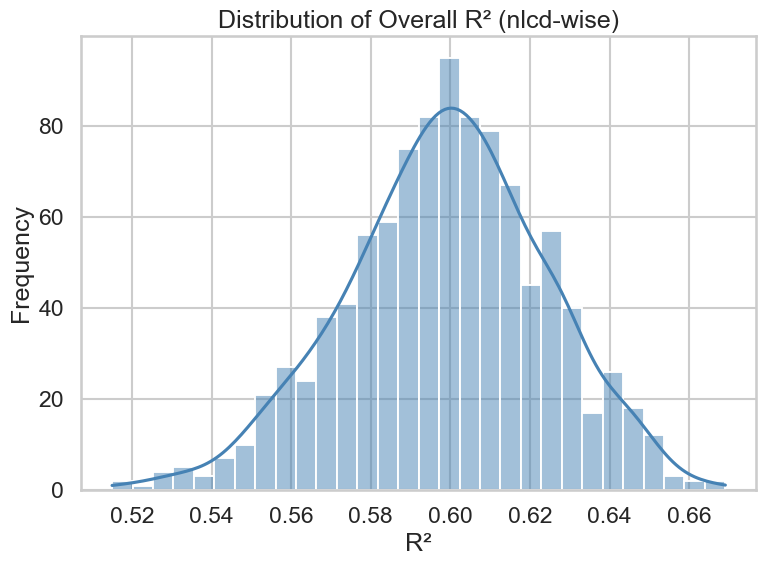

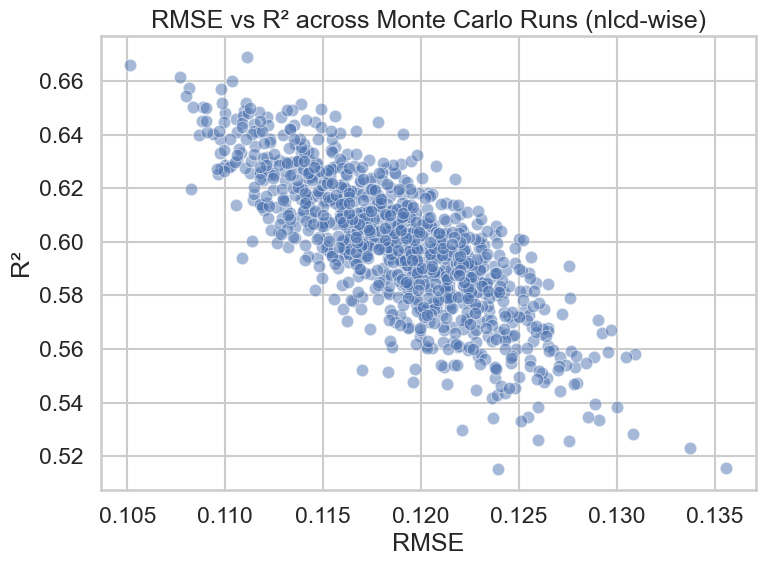

In [17]:
# Fire-wise evaluation

plot_mc_results(results_fire, mode="fire", save_prefix="fire_eval")

# NLCD-wise evaluation

plot_mc_results(results_nlcd, mode="nlcd", save_prefix="nlcd_eval")

In [18]:
# Per-fire Monte Carlo summar
# Filter only per-fire results
fire_results = results_fire[results_fire["Group"].str.startswith("fire_")].copy()

# Extract Fire name (e.g., "fire_Eaton" → "Eaton")
fire_results["Fire"] = fire_results["Group"].str.replace("fire_", "")

# --- Summary stats ---
fire_r2_stats = (
    fire_results
    .groupby("Fire")["R2"]
    .agg(n_iterations="count", mean="mean", median="median", std="std")
    .round(3)
    .sort_values("mean", ascending=False)
)

print("Monte Carlo R² by Fire (across iterations):")
print(fire_r2_stats)

Monte Carlo R² by Fire (across iterations):
           n_iterations   mean  median    std
Fire                                         
Hughes             1000  0.677   0.681  0.047
Palisades          1000  0.574   0.576  0.033
Eaton              1000  0.371   0.375  0.062


In [19]:
# Extract only NLCD-group rows from results_nlcd and parse NLCD codes
nlcd_results = results_nlcd[results_nlcd["Group"].str.startswith("nlcd_")].copy()

# Extract numeric NLCD code (e.g., "nlcd_42" → 42)
nlcd_results["NLCD_Code"] = nlcd_results["Group"].str.replace("nlcd_", "").astype(int)

# Map NLCD code to descriptive class name
nlcd_results["NLCD_Class"] = nlcd_results["NLCD_Code"].map(nlcd_classes)

# Compute summary stats for R² by NLCD class
r2_stats = (
    nlcd_results
    .groupby("NLCD_Class")["R2"]
    .agg(
        n_iterations="count",
        mean="mean",
        median="median",
        std="std"
    )
    .sort_values("mean", ascending=False)
    .round(3)
)

print("\nMonte Carlo R² by NLCD Class (across iterations):")
print(r2_stats)


Monte Carlo R² by NLCD Class (across iterations):
                      n_iterations   mean  median    std
NLCD_Class                                              
Shrub/Scrub                   1000  0.619   0.620  0.029
Woody Wetlands                  65  0.351   0.400  0.428
Evergreen Forest              1000  0.279   0.285  0.084
Mixed Forest                  1000  0.213   0.218  0.103
Grassland/Herbaceous           955  0.084   0.199  0.506


# Plots

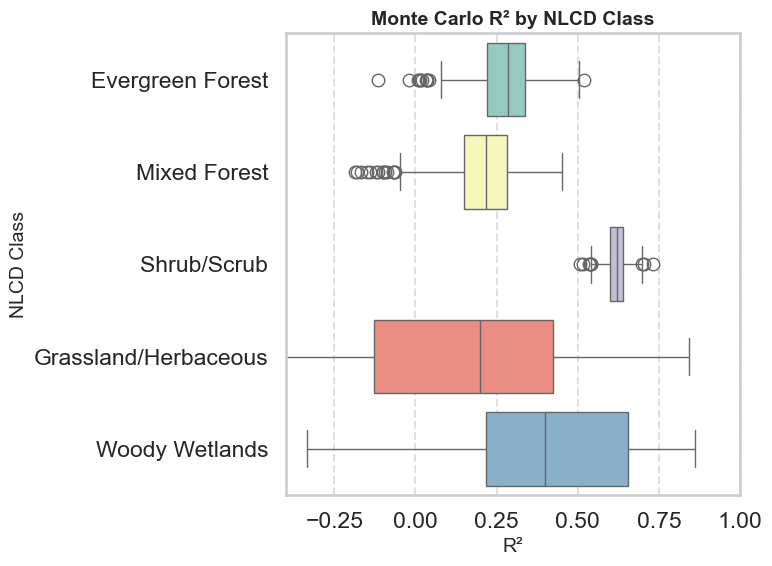

In [20]:
# Per NLCD Monte Carlo 
# Filter only NLCD results
nlcd_results = results_nlcd[results_nlcd["Group"].str.startswith("nlcd_")].copy()

# Extract NLCD code from "Group" (e.g., "nlcd_42" → 42)
nlcd_results["NLCD_Code"] = nlcd_results["Group"].str.replace("nlcd_", "").astype(int)

# Map NLCD codes to human-readable class names
nlcd_results["NLCD_Class"] = nlcd_results["NLCD_Code"].map(nlcd_classes)

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=nlcd_results,
    x="R2", y="NLCD_Class", 
    orient="h", palette="Set3"
)

plt.xlim(-0.4, 1.0)
plt.title("Monte Carlo R² by NLCD Class", fontsize=14, fontweight="bold")
plt.xlabel("R²", fontsize=14)
plt.ylabel("NLCD Class", fontsize=14)
plt.grid(True, axis="x", linestyle="--", alpha=0.6)

# Save high-quality figure
plt.savefig("/Users/megan/Desktop/figures-rfr-lafires/monte_carlo_r2_nlcd.png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


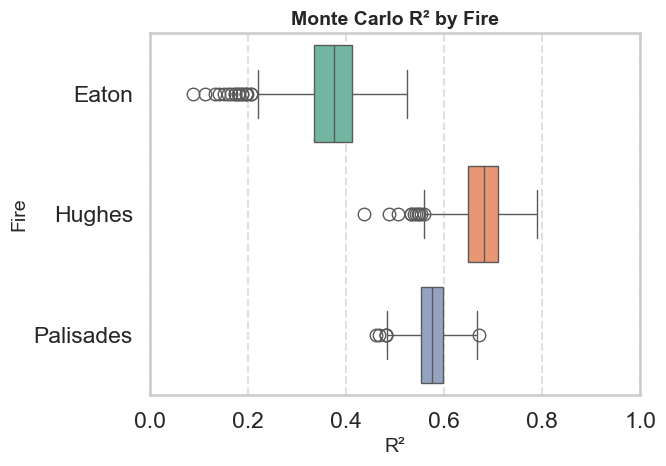

In [21]:
# Per Fire Monte Carlo
# Filter only fire results
fire_results = results_fire[results_fire["Group"].str.startswith("fire_")].copy()

# Extract fire name from Group (e.g., "fire_Eaton" → "Eaton")
fire_results["Fire"] = fire_results["Group"].str.replace("fire_", "")

# --- Plot ---
plt.figure(figsize=(7, 5))
sns.boxplot(
    data=fire_results,
    x="R2", y="Fire",
    orient="h", palette="Set2"
)

plt.xlim(0, 1.0)
plt.title("Monte Carlo R² by Fire", fontsize=14, fontweight="bold")
plt.xlabel("R²", fontsize=14)
plt.ylabel("Fire", fontsize=14)
plt.grid(True, axis="x", linestyle="--", alpha=0.6)

# Save high-quality figure
plt.savefig("/Users/megan/Desktop/figures-rfr-lafires/monte_carlo_r2_fire.png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


# Figure 5

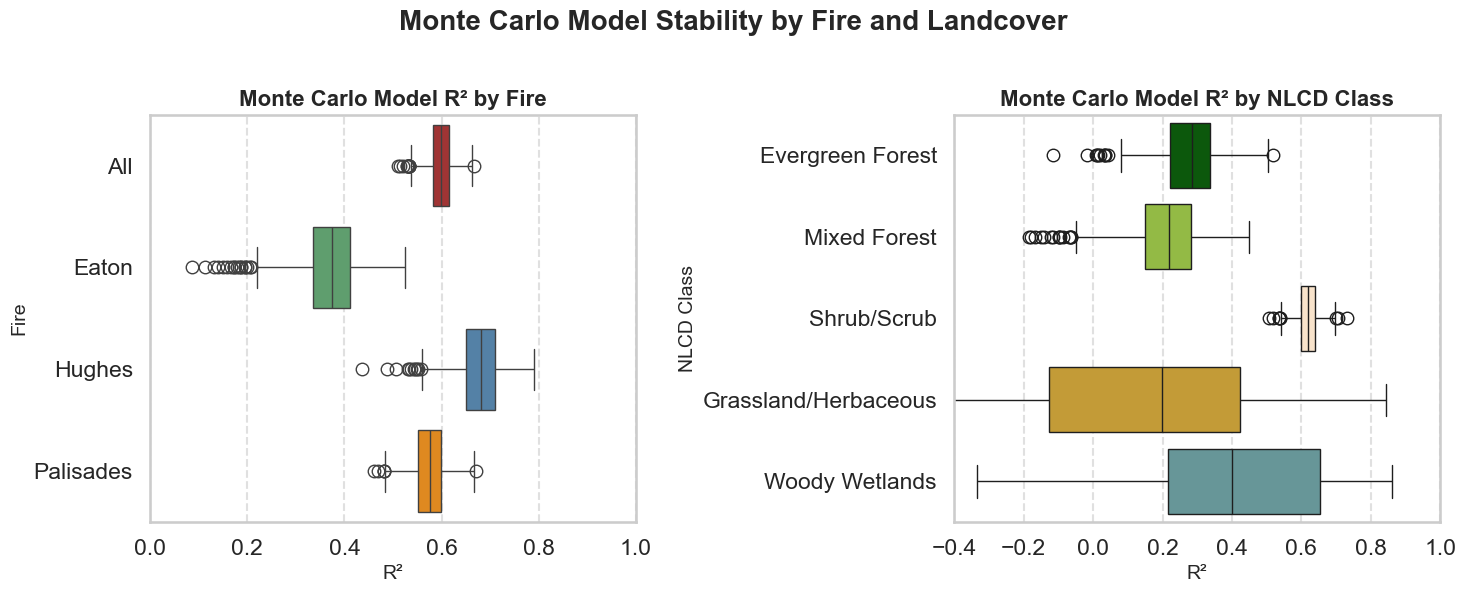

In [22]:
# -------------------------------------------
# Combined Monte Carlo Results: Fire + NLCD (with "All" box)
# -------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex=False)

# --- Per Fire Monte Carlo ---
fire_results = results_fire.copy()

# Extract "Fire" labels (e.g., "fire_Eaton" → "Eaton", keep "All" as is)
fire_results["Fire"] = fire_results["Group"].str.replace("fire_", "")
# Keep only fire_* and All
fire_results = fire_results[fire_results["Group"].str.startswith("fire_") | (fire_results["Group"] == "All")]

# Define fixed color mapping for fires + All
fire_palette = {
    "Eaton": "g",
    "Hughes": "steelblue",
    "Palisades": "darkorange",
    "All": "firebrick"
}

sns.boxplot(
    data=fire_results,
    x="R2", y="Fire",
    orient="h", palette=fire_palette,
    ax=axs[0]
)

axs[0].set_xlim(0, 1.0)
axs[0].set_title("Monte Carlo Model R² by Fire", fontsize=16, fontweight="bold")
axs[0].set_xlabel("R²", fontsize=14)
axs[0].set_ylabel("Fire", fontsize=14)
axs[0].grid(True, axis="x", linestyle="--", alpha=0.6)

# --- Per NLCD Monte Carlo ---
nlcd_results = results_nlcd[results_nlcd["Group"].str.startswith("nlcd_")].copy()
nlcd_results["NLCD_Code"] = nlcd_results["Group"].str.replace("nlcd_", "").astype(int)
nlcd_results["NLCD_Class"] = nlcd_results["NLCD_Code"].map(nlcd_classes)

nlcd_palette = {
    "Shrub/Scrub": "bisque",
    "Mixed Forest": "yellowgreen",
    "Evergreen Forest": "darkgreen",
    "Grassland/Herbaceous": "goldenrod",
    "Woody Wetlands": "cadetblue",
    "Emergent Herbaceous Wetlands": "mediumaquamarine"
}

sns.boxplot(
    data=nlcd_results,
    x="R2", y="NLCD_Class", 
    orient="h", palette=nlcd_palette,
    ax=axs[1]
)
axs[1].set_xlim(-0.4, 1.0)
axs[1].set_title("Monte Carlo Model R² by NLCD Class", fontsize=16, fontweight="bold")
axs[1].set_xlabel("R²", fontsize=14)
axs[1].set_ylabel("NLCD Class", fontsize=14)
axs[1].grid(True, axis="x", linestyle="--", alpha=0.6)

# Global layout
plt.suptitle("Monte Carlo Model Stability by Fire and Landcover", 
             fontsize=20, fontweight="bold", y=1.0)
plt.tight_layout()

# Save combined figure
plt.savefig("/Users/megan/Desktop/figures-rfr-lafires/monte_carlo_r2_combined.png",
            dpi=300, bbox_inches="tight", facecolor="white")
plt.show()